### Predicting Stock Prices Using Monte Carlo Methods in Python
- Determine the most likely price of SPY next year using a Monte Carlo simulation!

- O mercado de ações é uma das áreas mais estudadas da história. As pessoas vêm tentando prever preços futuros há décadas. A maioria, se não todas, as pessoas lutam com essa tarefa porque o mercado de ações é um processo estocástico. Os processos estocásticos são inerentemente difíceis ou impossíveis de prever com precisão devido à sua aleatoriedade. É aí que entram as simulações de Monte Carlo. Essas simulações são ótimas para determinar resultados de processos ou eventos que possuem variáveis ​​aleatórias. O mercado de ações, por exemplo, tem eventos aleatórios desconhecidos, como notícias, eventos mundiais, sentimento do investidor, etc. Tudo isso cria um sistema estocástico que torna praticamente impossível a criação de modelos para prever preços futuros.

- Neste artigo, tentaremos prever o preço das ações do SPY daqui a um ano usando dados históricos e estatísticas. Observe que este não é um conselho de investimento. Isto é apenas para fins educacionais e para demonstrar como os métodos de Monte Carlo podem ser aplicados ao mercado de ações. Esse modelo pode ser aplicado à sua ação, ETF ou criptomoeda favorita e, se desejado, pode ser expandido para qualquer processo estocástico para determinar o resultado mais provável de um evento aleatório. Vamos entrar no código

##### Importando pacotes
- Para este código, precisaremos dos seguintes pacotes:

- yfinance é usado para extrair dados financeiros históricos
- numpy é usado para calcular parâmetros estatísticos de mudanças no preço das ações
- random é usado para criar um resultado aleatório (chave para a simulação de Monte Carlo)
- pyplot é usado para visualizar nossos resultados
- norm é usada em conjunto com o pacote aleatório para randomizar um ganho de estoque diário (explicado mais adiante no artigo)

In [1]:
# Importing Packages
import yfinance as yf
import numpy as np
from random import random
import matplotlib.pyplot as plt
from scipy.stats import norm

#### Obtenção e exibição de dados históricos
- A próxima etapa é gerar dados financeiros históricos usando yfinance . Neste artigo, usaremos o código de ações SPY, ou o SPDR S&P 500 ETF Trust. Para extrair os dados, precisamos definir a data inicial e final do intervalo de interesse desejado. Eu usei 10 anos antes do dia em que escrevi isso. Vamos nos concentrar nos preços de fechamento diários do SPY, então vamos extrair esses dados do quadro de dados e plotá-los.

                  Open        High         Low       Close     Volume  \
Date                                                                    
2012-05-04  113.562486  114.201951  112.250758  112.316345  193927300   
2012-05-07  111.914608  112.775429  111.873627  112.398315  127765900   
2012-05-08  111.726077  112.127796  110.611111  111.947433  213377700   
2012-05-09  110.758697  111.996632  110.258602  111.283386  220752500   
2012-05-10  112.053978  112.193359  111.258757  111.512901  150600000   

            Dividends  Stock Splits  
Date                                 
2012-05-04        0.0             0  
2012-05-07        0.0             0  
2012-05-08        0.0             0  
2012-05-09        0.0             0  
2012-05-10        0.0             0  
                 Close
Date                  
2012-05-04  112.316345
2012-05-07  112.398315
2012-05-08  111.947433
2012-05-09  111.283386
2012-05-10  111.512901
...                ...
2022-04-27  413.775543
2022-04-28  424

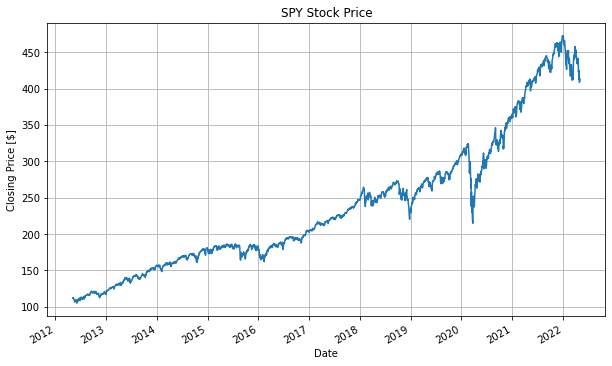

In [2]:
# Defining the Ticker
ticker = yf.Ticker('SPY')

# Obtaining Historical Market Data
start_date = '2012-05-04'
end_date = '2022-05-04'
hist = ticker.history(start=start_date, end=end_date)
print(hist.head())

# Pulling Closing Price Data
hist = hist[['Close']]
print(hist)

# Plotting Price Data
hist['Close'].plot(title="SPY Stock Price", ylabel=
                   "Closing Price [$]", figsize=[10, 6])
plt.grid()

In [3]:
close_price = [hist.iloc[-1, 0]]
close_price

[412.89300537109375]

- O código acima gera a seguinte saída e gráfico. Observe que a função head() é usada para plotar as primeiras cinco linhas do quadro de dados hist .

#### Estatísticas de ações
- Vamos analisar os preços de fechamento do SPY para uso posterior. Primeiro, precisaremos criar algumas listas: days para fins de plotagem e price_orig para usar os dados de preço de fechamento do quadro de dados hist . Criamos mais uma lista, change , que é a porcentagem de mudança diária do SPY nos últimos 10 anos. Usando change e numpy , podemos calcular a média e o desvio padrão das mudanças de preço durante o período de interesse. Vamos usá-los em nossos loops de Monte Carlo a seguir.

- A saída para esta seção:

In [3]:
# Create Day Count, Price, and Change Lists
days = [i for i in range(1, len(hist['Close'])+1)]
price_orig = hist['Close'].tolist()
change = hist['Close'].pct_change().tolist()
change = change[1:]  # Removing the first term since it is NaN

# Statistics for Use in Model
mean = np.mean(change)
std_dev = np.std(change)
print('\nMean percent change: ' + str(round(mean*100, 2)) + '%')
print('Standard Deviation of percent change: ' +   
      str(round(std_dev*100, 2)) + '%')


Mean percent change: 0.06%
Standard Deviation of percent change: 1.04%


#### Preparação para simulação
- Antes de começarmos a parte de Monte Carlo, precisamos configurar algumas coisas para analisar nossos resultados. Primeiro, precisamos definir o número de simulações que queremos executar, simulações e o número de dias que estamos prevendo, days_to_sim . Neste código, vamos simular por 1 ano (ou 252 dias de negociação) e realizar 200 simulações (escolhidas arbitrariamente, quanto mais, melhor).

- Em seguida, vamos inicializar um gráfico. Configurá-lo antes da simulação, nos permite adicionar linhas após cada ano previsto. Observe que também plotamos os dados originais de 10 anos, mas os cortamos após 2.000 dias (para visualizar melhor as linhas de previsão). Por fim, inicializamos duas listas que rastrearão o preço de fechamento do ano de uma previsão, close_end , e se esse preço de fechamento estiver acima do preço de fechamento de 4/5/2022, above_close .

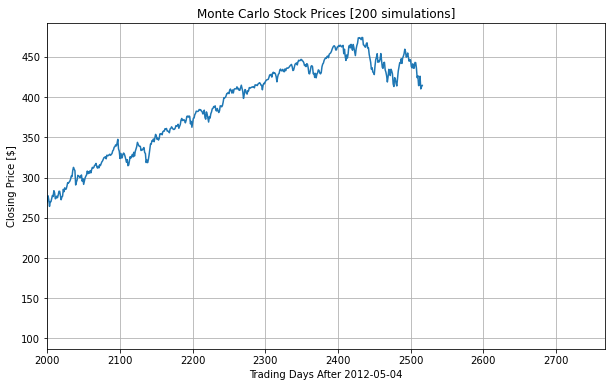

In [4]:
# Simulation Number and Prediction Period
simulations = 200 # Change for more results
days_to_sim = 1*252 # Trading days in 1 year

# Initializing Figure for Simulation
fig = plt.figure(figsize=[10, 6])
plt.plot(days, price_orig)
plt.title("Monte Carlo Stock Prices [" + str(simulations) + 
          " simulations]")
plt.xlabel("Trading Days After " + start_date)
plt.ylabel("Closing Price [$]")
plt.xlim([2000, len(days)+days_to_sim])
plt.grid()

# Initializing Lists for Analysis
close_end = []
above_close = []

#### Simulação de Monte Carlo
- Agora que configuramos tudo, podemos passar para o pão com manteiga do artigo. Esta parte do código representa a simulação de Monte Carlo e o que usaremos para prever o preço das ações do SPY. Aqui, temos um loop for externo que percorre o número de simulações que definimos anteriormente, simulações . Em seguida, definimos duas listas: num_days , uma lista que rastreia os dias após 4/5/2022 para fins de plotagem e close_price , uma lista que rastreia o preço de fechamento do SPY após 4/5/2022 para uma única simulação.

- O próximo loop é executado pelo número de dias que escolhemos prever (252 dias de negociação). Nesse loop, primeiro adicionamos um dia à nossa lista num_days . Em seguida, aleatorizamos uma mudança percentual para aquele dia usando a função ppf , ponto percentual, da norma . A função ppf pega uma probabilidade aleatória, nossa média e desvio padrão (calculado anteriormente), e gera uma mudança percentual equivalente à probabilidade aleatória em uma distribuição normal.

- Em seguida, usamos essa alteração percentual aleatória para calcular o próximo preço de fechamento com base no preço de fechamento anterior. Em seguida, determinamos se o preço de fechamento após o ano de simulação está acima do preço de fechamento em 04/05/2022 e atribuímos 1 se for ou 0 se não for. Finalmente, podemos anexar o preço de fechamento previsto após um ano à nossa variável close_end e plotar nossos dias em relação à lista de preços de fechamento.

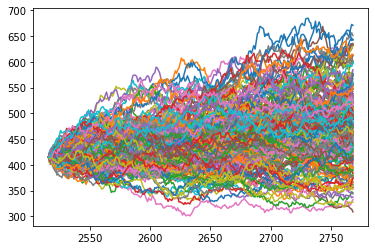

In [10]:
# For Loop for Number of Simulations Desired
for i in range(simulations):
    num_days = [days[-1]]
    close_price = [hist.iloc[-1, 0]]
    
    # For Loop for Number of Days to Predict
    for j in range(days_to_sim):
        num_days.append(num_days[-1]+1)
        perc_change = norm.ppf(random(), loc=mean, scale=std_dev)
        close_price.append(close_price[-1]*(1+perc_change))

    if close_price[-1] > price_orig[-1]:
        above_close.append(1)
    else:
        above_close.append(0)

    close_end.append(close_price[-1])
    plt.plot(num_days, close_price)

#### Obtendo resultados
- A etapa final é exibir e interpretar os resultados das simulações. Podemos calcular o preço médio de fechamento e a variação percentual após as 200 simulações. Também podemos determinar a probabilidade de o SPY aumentar após um ano dividindo o total de vezes que o preço de fechamento previsto está acima do preço de fechamento de 04/05/2022 pelo número de simulações (ou o comprimento da lista).


Predicted closing price after 200 simulations: $1437.51
Predicted percent increase after 1 year: 246.73%
Probability of stock price increasing after 1 year: 239.5%


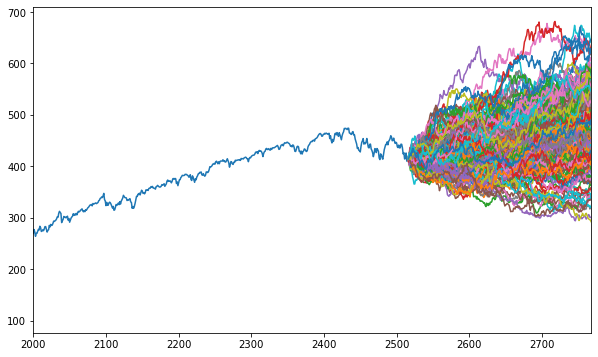

In [16]:
# Average Closing Price and Probability of Increasing After 1 Year
average_closing_price = sum(close_end)/simulations
average_perc_change = (average_closing_price-
                       price_orig[-1])/price_orig[-1]
probability_of_increase = sum(above_close)/simulations
print('\nPredicted closing price after ' + str(simulations) + 
      ' simulations: $' + str(round(average_closing_price, 2)))
print('Predicted percent increase after 1 year: ' + 
      str(round(average_perc_change*100, 2)) + '%')
print('Probability of stock price increasing after 1 year: ' + 
      str(round(probability_of_increase*100, 2)) + '%')

# Displaying the Monte Carlo Simulation Lines
#plt.plot(num_days, close_price)
fig = plt.figure(figsize=[10, 6])
plt.plot(days, price_orig)
plt.xlim([2000, len(days)+days_to_sim])

for i in range(simulations):
    num_days = [days[-1]]
    close_price = [hist.iloc[-1, 0]]
    
    # For Loop for Number of Days to Predict
    for j in range(days_to_sim):
        num_days.append(num_days[-1]+1)
        perc_change = norm.ppf(random(), loc=mean, scale=std_dev)
        close_price.append(close_price[-1]*(1+perc_change))

    if close_price[-1] > price_orig[-1]:
        above_close.append(1)
    else:
        above_close.append(0)

    close_end.append(close_price[-1])
    plt.plot(num_days, close_price)
#plt.show()

- Observe que o preço médio previsto após um ano é de US$ 483,89 (aumento de 16,21% em relação a 04/05/2022). Há também uma probabilidade de 77,0% de o SPY aumentar após um ano. À medida que você aumenta o número de simulações, notará que o preço médio, a variação percentual média e a probabilidade de o estoque aumentar convergem em determinados valores. Você também pode executar o código com uma simulação para mostrar um resultado aleatório a cada vez (mostrado abaixo)

(2000.0, 2768.0)

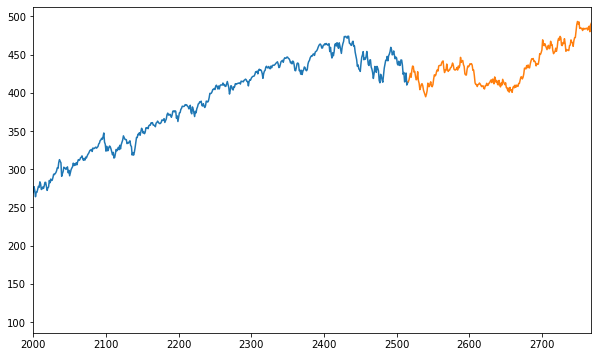

In [17]:
# Displaying the Monte Carlo Simulation Lines

fig = plt.figure(figsize=[10, 6])
plt.plot(days, price_orig)
plt.plot(num_days, close_price)
plt.xlim([2000, len(days)+days_to_sim])

- Novamente, este não é um conselho financeiro, então não jogue todas as suas economias no mercado de ações com base nesses resultados. Este é simplesmente um exemplo de como usar simulações de Monte Carlo e dados históricos para determinar o resultado mais provável em um evento aleatório, como o mercado de ações. Sinta-se à vontade para construir o modelo e implementar seu próprio toque!



#### Referência:
https://medium.com/illumination/predicting-stock-prices-using-monte-carlo-methods-in-python-2b099c408162